In [1]:
from cideMOD import (
    CellParser,
    ErrorCheck,
    NDProblem,
    Problem,
    SolverCrashed,
    Trigger,
    init_results_folder,
    ModelOptions,
    CSI
)
import json 

In [2]:
overwrite = False
case = "Safari_2009"
data_path = "../../data/data_{}".format(case)

model_options = ModelOptions(mode='P2D', clean_on_exit=False, solve_SEI=True)

save_path = init_results_folder(
    case, overwrite=overwrite, copy_files=[f"{data_path}/params_OCV.json"]
)

cell_ocv = CellParser("params_OCV.json", data_path=data_path)
cell_cy = CellParser("params_cycling.json", data_path=data_path)
cell = json.load(open(data_path+"/params_cycling.json"))

Saving results to /home/fenics/shared/cideMOD/examples/results_Safari_2009
Capacidad Anodo: 2.295594689447843
Capacidad Catodo: 1.9868852574347429
Capacidad Celda: 1.9868852574347429
Capacidad Anodo: 1.6977835724041341
Capacidad Catodo: 2.1634972803178316
Capacidad Celda: 1.6977835724041341


## Cycling

In [3]:
V_app = 3.9
I_app = 0

days = 484
hours = days * 24
minutes = hours * 60
seconds = minutes * 60
t_f = seconds

In [4]:
cycling = {
            "name": "Discharge Cycle",
            "type": "Cycle",
            "count": 800,
            "steps": [
                {
                    "name": "Discharge",
                    "type": "Current", 
                    "value": "-0.5*1.8", 
                    "unit": "A", 
                    "t_max": {"value": 2.5, "unit": "h"},
                    "store_delay": -1 ,
                    "min_step": 30,
                    "events": [
                        {
                            "type": "Voltage",
                            "value": 2,  
                            "unit": "V",  
                            "atol": 1e-4, 
                            "rtol": 1e-3,
                            "goto": "Next" 
                        }
                    ]
                },
                {
                    "name": "Charge",
                    "type": "Current", 
                    "value": "0.5*1.8", 
                    "unit": "A", 
                    "t_max": {"value": 2.5, "unit": "h"},
                    "store_delay": -1 ,
                    "min_step": 30,
                    "events": [
                        {
                            "type": "Voltage",
                            "value": 4.2,  
                            "unit": "V",  
                            "atol": 1e-4, 
                            "rtol": 1e-3,
                            "goto": "CV" 
                        }
                    ]
                }
            ]}

cycling_test_plan = {
    'initial_state': {
        'SOC': 1,
        'exterior_temperature': 298
    },
    'steps': [cycling]
}

### Reaction limited case

In [5]:
cell["negativeElectrode"]["SEI"]["solventDiffusion"].update({"value": 1.3e-15})
cell["negativeElectrode"]["SEI"]["rateConstant"].update({"value": 1.36e-12})
bms_rl = CSI(cell, model_options, data_path, name=case, overwrite=overwrite)
bms_rl.read_test_plan(cycling_test_plan)
bms_rl.run_test_plan()

problem_rl = bms_rl.problem

Capacidad Anodo: 1.6977835724041341
Capacidad Catodo: 2.1634972803178316
Capacidad Celda: 1.6977835724041341
Saving results to /home/fenics/shared/cideMOD/examples/results_Safari_2009
Initial state:
{'SOC': 1, 'exterior_temperature': 298}
Steps:
0 -  Cycle 'Discharge Cycle' repeats 50 times:
	 0 - CC_Discharge: Apply (-0.5*1.8)*1 A during 2 hours 30 minutes until [Voltage Trigger at 2 V]
	 1 - CC_Charge: Apply (0.5*1.8)*1 A during 2 hours 30 minutes until [Voltage Trigger at 4.2 V]
Building mesh for P2D problem with 3 components and 90 nodes.
Finished building mesh
Building problem setup
 - Build cell parameters - Done 
 - Initializing state - Done 
 - Build variational formulation - Done 
Problem Setup finished.
Problem has 556.0 dofs.

-- Cycle 'Discharge Cycle', iteration number 0 --
CC_Discharge: Apply (-0.5*1.8)*1 A during 2 hours 30 minutes until [Voltage Trigger at 2 V]
Solving ...
Voltage is 2 V at 6984.07 s -01	Time: 1h 56min 22s

CC_Charge: Apply (0.5*1.8)*1 A during 2 hours 

### Diffusion limited case

In [6]:
cell["negativeElectrode"]["SEI"]["solventDiffusion"].update({"value": 6.8e-21})
cell["negativeElectrode"]["SEI"]["rateConstant"].update({"value": 1.36e-7})
bms_dl = CSI(cell, model_options, data_path, name=case, overwrite=overwrite)
bms_dl.read_test_plan(cycling_test_plan)
bms_dl.run_test_plan()

problem_dl = bms_dl.problem

Capacidad Anodo: 1.6977835724041341
Capacidad Catodo: 2.1634972803178316
Capacidad Celda: 1.6977835724041341
Saving results to /home/fenics/shared/cideMOD/examples/results_Safari_2009
Initial state:
{'SOC': 1, 'exterior_temperature': 298}
Steps:
0 -  Cycle 'Discharge Cycle' repeats 50 times:
	 0 - CC_Discharge: Apply (-0.5*1.8)*1 A during 2 hours 30 minutes until [Voltage Trigger at 2 V]
	 1 - CC_Charge: Apply (0.5*1.8)*1 A during 2 hours 30 minutes until [Voltage Trigger at 4.2 V]
Building mesh for P2D problem with 3 components and 90 nodes.
Finished building mesh
Building problem setup
 - Build cell parameters - Done 
 - Initializing state - Done 
 - Build variational formulation - Done 
Problem Setup finished.
Problem has 556.0 dofs.

-- Cycle 'Discharge Cycle', iteration number 0 --
CC_Discharge: Apply (-0.5*1.8)*1 A during 2 hours 30 minutes until [Voltage Trigger at 2 V]
Solving ...
Voltage is 2 V at 6983.72 s -01	Time: 1h 56min 21s

CC_Charge: Apply (0.5*1.8)*1 A during 2 hours 

# Compare results

In [1]:
import matplotlib.pyplot as plt
import numpy
from scipy.interpolate import interp1d
matplotlib.use('Agg')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

safari_rl = numpy.genfromtxt("../../data/data_Safari_2009/SEI_resistance_rl.txt", delimiter='\t')
safari_dl = numpy.genfromtxt("../../data/data_Safari_2009/SEI_resistance_dl.txt", delimiter='\t')

### SEI resistance

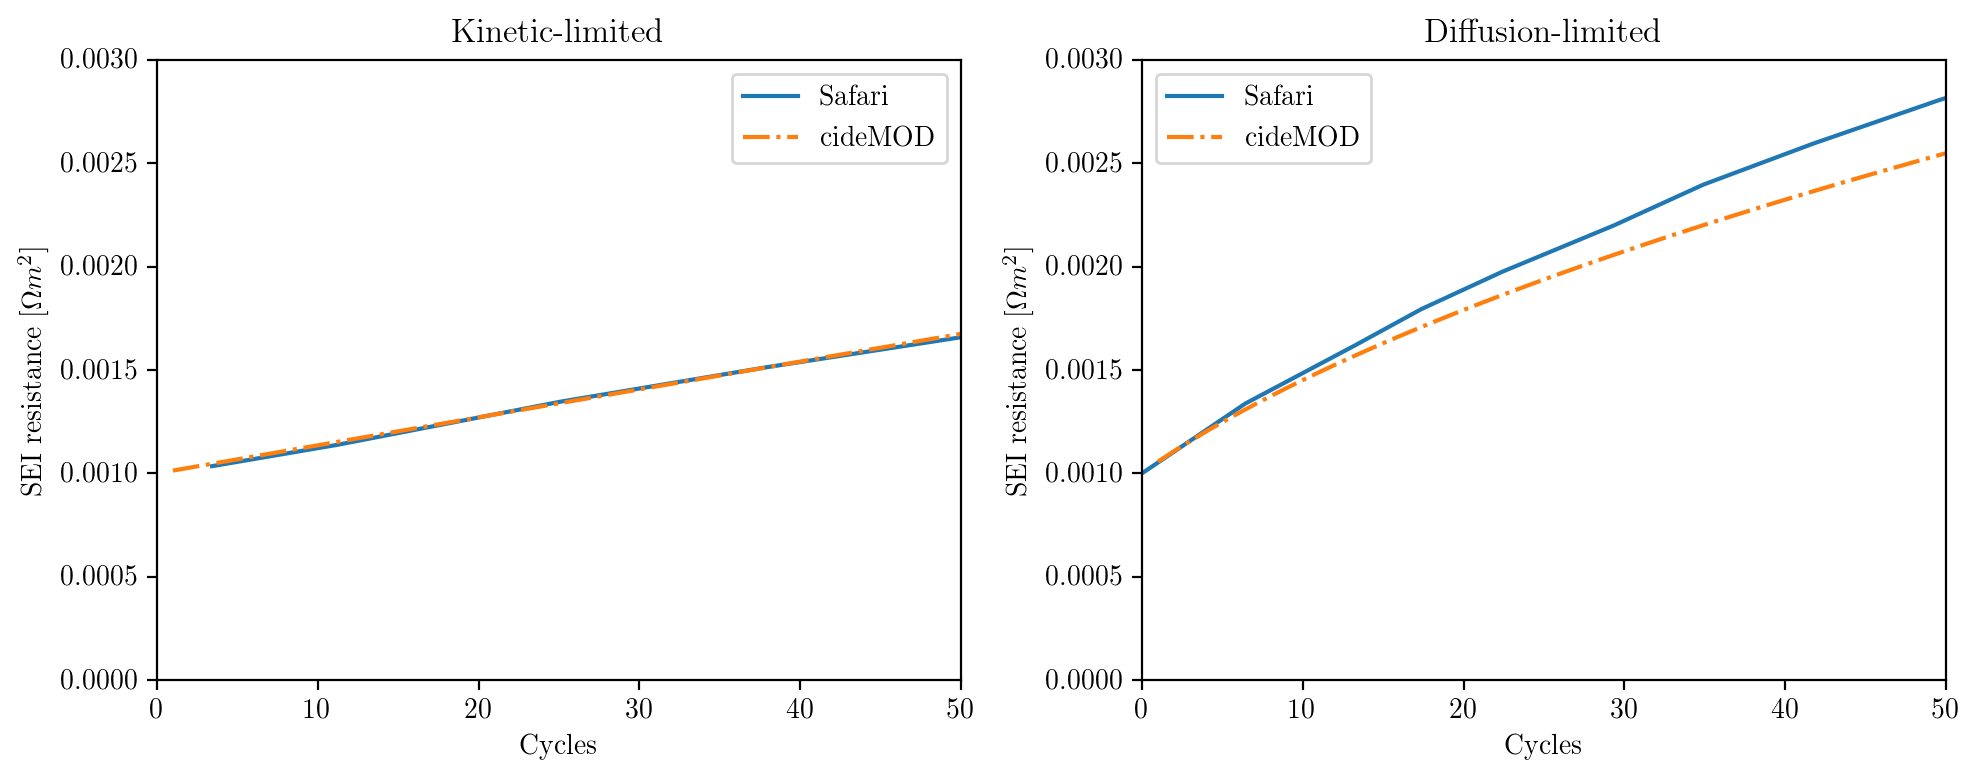

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

# Reaction limited
cur = problem_rl.WH.global_var_arrays[2]
index = numpy.append(numpy.where(numpy.diff(cur)<(-0.5*1.8))[0], len(cur)-1)
nCycles = len(index)
cycles_rl = numpy.arange(1,nCycles+1)
thickness = problem_rl.WH.global_var_arrays[-1]
av_thickness_rl = numpy.array(thickness)[index]

ax1.plot(safari_rl[:,0], safari_rl[:,1], "-")
ax1.plot(cycles_rl, av_thickness_rl/problem_rl.anode.SEI.kappa, "-.")
ax1.set_xlabel("Cycles")
ax1.set_ylabel("SEI resistance [$\Omega m^2$]")
ax1.legend(["Safari", "cideMOD"], loc="best")
# ax1.set_ylim([0, 0.003])
ax1.set_xlim([0, 800])
ax1.title.set_text("Kinetic-limited")

cur = problem_dl.WH.global_var_arrays[2]
index = numpy.append(numpy.where(numpy.diff(cur)<(-0.5*1.8))[0], len(cur)-1)
nCycles = len(index)
cycles_dl = numpy.arange(1,nCycles+1)
thickness = problem_dl.WH.global_var_arrays[-1]
av_thickness_dl = numpy.array(thickness)[index]

ax2.plot(safari_dl[:,0], safari_dl[:,1], "-")
ax2.plot(cycles_dl, av_thickness_dl/problem_dl.anode.SEI.kappa, "-.")
ax2.set_xlabel("Cycles")
ax2.set_ylabel("SEI resistance [$\Omega m^2$]")
ax2.legend(["Safari", "cideMOD"], loc="best")
# ax2.set_ylim([0, 0.003])
ax2.set_xlim([0, 800])
ax2.title.set_text("Diffusion-limited")

plt.tight_layout()
plt.show()
plt.savefig("Cycles.png")

### RMSE cycling

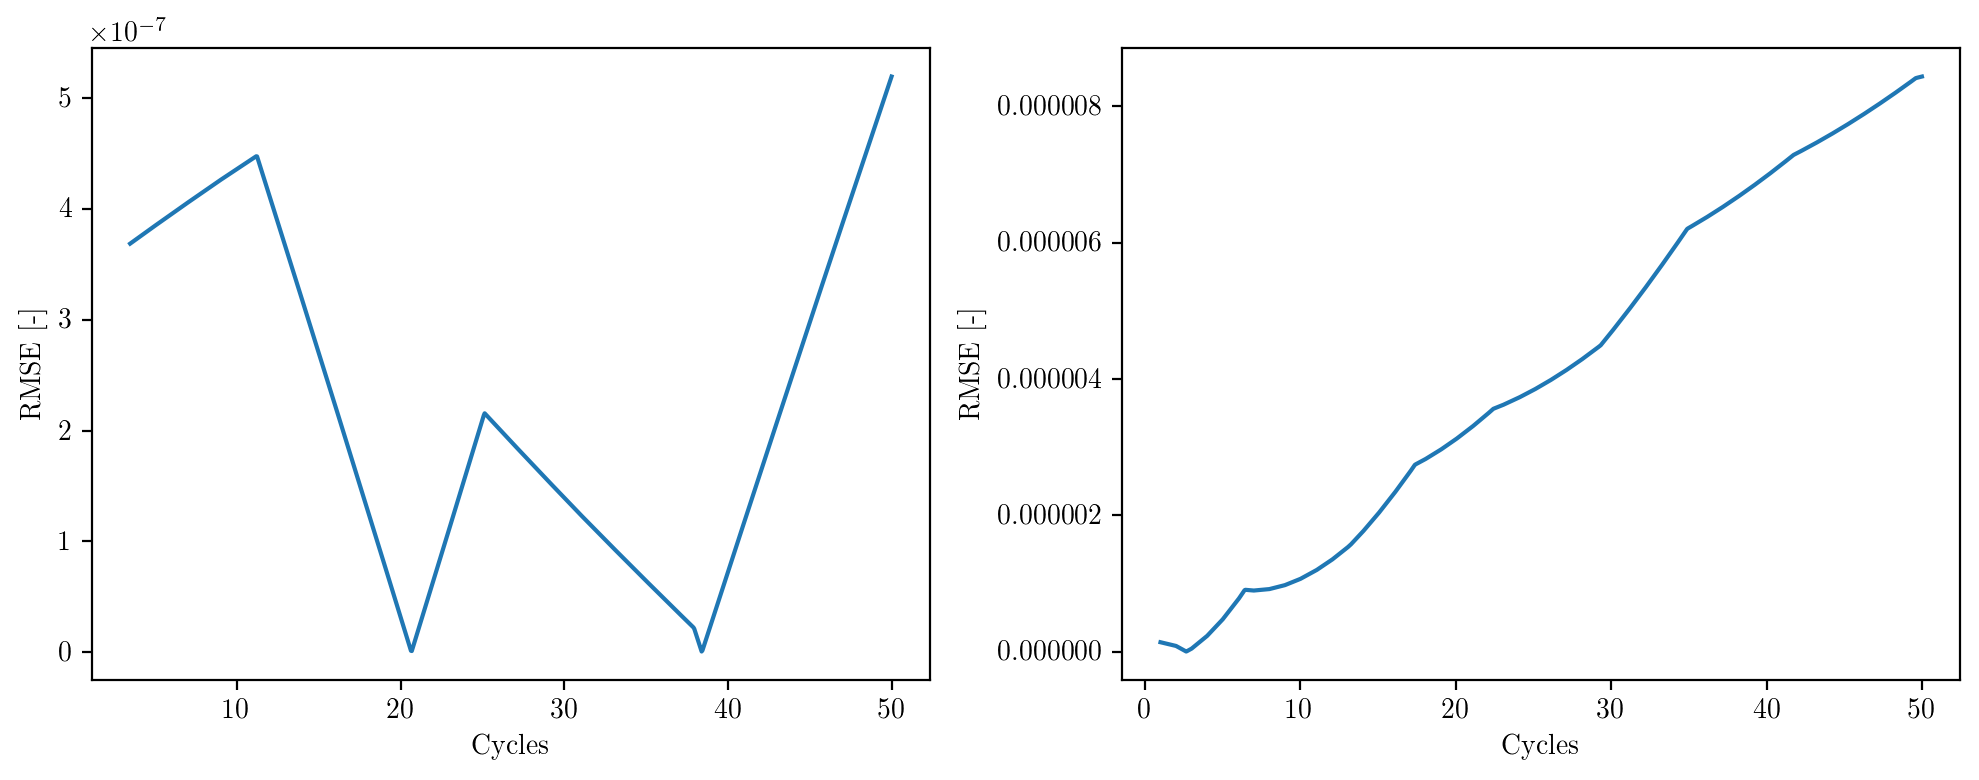

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)
time = numpy.linspace(0, 800, 800)

real_dl = interp1d(safari_dl[:,0], safari_dl[:,1], bounds_error=False)
cidemod_dl = interp1d(cycles_dl, av_thickness_dl.flatten()/problem_dl.anode.SEI.kappa, bounds_error=False)
real_rl = interp1d(safari_rl[:,0], safari_rl[:,1], bounds_error=False)
cidemod_rl = interp1d(cycles_rl, av_thickness_rl.flatten()/problem_rl.anode.SEI.kappa, bounds_error=False)

# plot the RMSE over cycles
ax1.plot(time, numpy.sqrt((real_rl(time)-cidemod_rl(time))**2/len(time)), "-")
ax1.set_xlabel("Cycles")
ax1.set_ylabel("RMSE [-]")
ax1.title.set_text("Kinetic-limited")

# plot the RMSE over cycles
ax2.plot(time, numpy.sqrt((real_dl(time)-cidemod_dl(time))**2/len(time)), "-")
ax2.set_xlabel("Cycles")
ax2.set_ylabel("RMSE [-]")
ax2.title.set_text("Diffusion-limited")

plt.tight_layout()
plt.show()
plt.savefig("Cycles_RMSE.png")

### Voltage comparison

In [2]:
safari_rl = numpy.genfromtxt("../data/data_Safari_2009/voltage_rl.txt", delimiter='\t')
safari_dl = numpy.genfromtxt("../data/data_Safari_2009/voltage_dl.txt", delimiter='\t')


# Reaction limited
cur = problem_rl.WH.global_var_arrays[2]
index = numpy.append(numpy.where(numpy.diff(cur)<(-0.5*1.8))[0], len(cur)-1)

ax1.plot(safari_rl[:,0], safari_rl[:,1], "-")
ax1.plot(problem_rl.WH.global_var_arrays[3][0:index[0]], problem_rl.WH.global_var_arrays[1][0:index[0]], "-.")
ax1.set_xlabel("Capacity [Ah]")
ax1.set_ylabel("Voltaje [V]")
ax1.legend(["Safari", "cideMOD"], loc="best")
# ax1.set_ylim([0, 0.003])
# ax1.set_xlim([0, 800])
ax1.title.set_text("Kinetic-limited")

cur = problem_dl.WH.global_var_arrays[2]
index = numpy.append(numpy.where(numpy.diff(cur)<(-0.5*1.8))[0], len(cur)-1)

ax2.plot(safari_dl[:,0], safari_dl[:,1], "-")
ax2.plot(problem_dl.WH.global_var_arrays[3][0:index[0]], problem_dl.WH.global_var_arrays[1][0:index[0]], "-.")
ax2.set_xlabel("Capacity [Ah]")
ax2.set_ylabel("Voltaje [V]")
ax2.legend(["Safari", "cideMOD"], loc="best")
ax2.title.set_text("Diffusion-limited")

plt.tight_layout()
plt.show()
plt.savefig("Cycles_voltaje.png")

NameError: name 'numpy' is not defined

## Compare cycling parameters and OCV parameters

In [1]:
safari_Q_cycling = numpy.genfromtxt("../data/data_Safari_2009/capacity_loss_cycling.txt", delimiter='\t')
safari_Q_OCV = numpy.genfromtxt("../data/data_Safari_2009/capacity_loss_ocv.txt", delimiter='\t')

NameError: name 'pd' is not defined

#### OCV

In [ ]:
problem_ocv = Problem(cell_ocv, model_options)
problem_ocv.set_cell_state(0.99, 273 + 25, 273 + 25)
problem_ocv.setup()

v_min = Trigger(2.5, "v")
status = problem_ocv.solve_ie(
    min_step=5, max_step=30*24*3600, i_app=I_app, t_f=t_f, store_delay=-1, adaptive=True, triggers=[v_min]
)
err = ErrorCheck(problem_ocv, status)

if isinstance(status, SolverCrashed):
    raise status.args[0]

Building mesh for P2D problem with 3 components and 90 nodes.
Finished building mesh
Building problem setup
 - Build cell parameters - Done 
 - Initializing state - Done 
 - Build variational formulation - Done 
Problem Setup finished.
Problem has 556.0 dofs.

Solving ...
Reached max time 41817600.00 0	Time: 483d 11h 22min 52s



#### Cycling

In [ ]:
problem_cy = Problem(cell_cy, model_options)
problem_cy.set_cell_state(0.99, 273 + 25, 273 + 25)
problem_cy.setup()

v_min = Trigger(2.5, "v")
status = problem_cy.solve_ie(
    min_step=5, max_step=30*24*3600, i_app=I_app, t_f=t_f, store_delay=-1, adaptive=True, triggers=[v_min]
)
err = ErrorCheck(problem_cy, status)

if isinstance(status, SolverCrashed):
    raise status.args[0]

Building mesh for P2D problem with 3 components and 90 nodes.
Finished building mesh
Building problem setup
 - Build cell parameters - Done 
 - Initializing state - Done 
 - Build variational formulation - Done 
Problem Setup finished.
Problem has 556.0 dofs.

Solving ...
Reached max time 41817600.00 0	Time: 483d 15h 26min 42s



#### Plot

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

# plot results over time
ax1.plot(safari_Q_cycling[:,0], safari_Q_cycling[:,1]*100, "-")
ax1.plot(numpy.array(problem_cy.WH.global_var_arrays[0])/3600/24, numpy.array(problem_cy.WH.global_var_arrays[-2])/1.8*100, "-")
ax1.set_xlabel("Time [days]")
ax1.set_ylabel(r"Capacity loss [\%]")
ax1.legend(["Safari", "cideMOD"], loc="best")
ax1.set_xlim([0, max(safari_Q_cycling[:,0])])

ax2.plot(safari_Q_OCV[:,0], safari_Q_OCV[:,1]*100, "-")
ax2.plot(numpy.array(problem_ocv.WH.global_var_arrays[0])/3600/24, numpy.array(problem_ocv.WH.global_var_arrays[-2])/1.8*100, "-")
ax2.set_xlabel("Time [days]")
ax2.set_ylabel(r"Capacity loss [\%]")
ax2.legend(["Safari", "cideMOD"], loc="best")
ax2.set_xlim([0, max(safari_Q_OCV[:,0])])

plt.tight_layout()
plt.show()
plt.savefig("Storage.png")


### RSME

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=200)
time = numpy.linspace(0, max([safari_Q_cycling[:,0][-1], problem_cy.WH.global_var_arrays[0][-1]/3600/24, 
                              safari_Q_OCV[:,0][-1], problem_ocv.WH.global_var_arrays[0][-1]/3600/24]), 1000)

real_cy = interp1d(safari_Q_cycling[:,0], safari_Q_cycling[:,1], bounds_error=False)
cidemod_cy = interp1d(numpy.array(problem_cy.WH.global_var_arrays[0])/3600/24, numpy.array(problem_cy.WH.global_var_arrays[-2])/1.8, bounds_error=False)
real_ocv = interp1d(safari_Q_OCV[:,0], safari_Q_OCV[:,1], bounds_error=False)
cidemod_ocv = interp1d(numpy.array(problem_ocv.WH.global_var_arrays[0])/3600/24, numpy.array(problem_ocv.WH.global_var_arrays[-2])/1.8, bounds_error=False)

# plot the RMSE over cycles
ax1.plot(time, numpy.sqrt((real_cy(time)-cidemod_cy(time))**2/len(time)), "-")
ax1.set_xlabel("Time")
ax1.set_ylabel("RMSE [-]")

# plot the RMSE over cycles
ax2.plot(time, numpy.sqrt((real_ocv(time)-cidemod_ocv(time))**2/len(time)), "-")
ax2.set_xlabel("Time")
ax2.set_ylabel("RMSE [-]")

plt.tight_layout()
plt.show()
plt.savefig("Storage_RMSE.png")
